# I - CREATE & PREPROCESS DATASET

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from  sklearn import decomposition

In [3]:
def load_data(file : str) -> pd.DataFrame: 
  """ Load the dataset. """
  na_val = ["n/a", "na", "?", "NaN"]
  df = pd.read_csv(file, na_values = na_val)
  df = df.loc[:, ~df.columns.str.match('Unnamed')]
  return df

In [4]:
def select_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.loc[:, ~df.columns.str.match('duree')]
    df = df.loc[:, ~df.columns.str.match('radiofrequence')]
    df = df.loc[:, ~df.columns.str.match('delais_ercp_spyglass')]
    df = df.loc[:, ~df.columns.str.match('prothese')]
    df = df.loc[:, ~df.columns.str.match('stenose')]
    df = df.loc[:, ~df.columns.str.match('biopsies')]
    return df
    


In [5]:
def replace_na_values(df : pd.DataFrame) -> pd.DataFrame:
  """ Return the data with the na values filled by the mean of the column. """
  n = len(df.columns)
  for i in range(n):
    index = 0
    while type(df[df.columns[i]][index]) == float:
        index += 1
    if type(df[df.columns[i]][index]) != str:
        df[df.columns[i]] = df[df.columns[i]].fillna(df[df.columns[i]].mean())   
    else:
        df[df.columns[i]] = df[df.columns[i]].fillna(df[df.columns[i]].mode()[0])
  df = df.applymap(lambda x: x.replace("\t", "") if type(x) == str else x)
  df = df.applymap(lambda x: x.replace(" ", "") if type(x) == str else x)
  return df

In [6]:
def load_and_preprocess_data(file : str) -> pd.DataFrame: 
  """ Preprocess the data. """
  return replace_na_values(select_features(load_data(file)))

In [7]:
def create_datasets(db):    
    data = load_and_preprocess_data(db)
    X = pd.DataFrame(data.drop(data.columns[-1],axis=1))
    y = data[data.columns[-1]]
    return X, y

In [8]:
db = load_and_preprocess_data('../medical_data3.csv')

# II - TREE BASED MODEL

In [9]:
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

In [10]:
def train(X, y, classifier, kfold_num_splits=5):
   max = 0
   kf = KFold(n_splits=kfold_num_splits, shuffle=True)
   for train_index, test_index in kf.split(X):
      X_train = X.iloc[train_index,:]
      y_train = y[train_index]
      X_test  = X.iloc[test_index,:]
      y_test  = y[test_index]
      classifier.fit(X_train, y_train)
      predictions = classifier.predict(X_test)
      if max < metrics.accuracy_score(y_test, predictions):
         max = metrics.accuracy_score(y_test, predictions)
         X_train_f = X.iloc[train_index, :]
         y_train_f = y[train_index]
         X_test_f  = X.iloc[test_index, :]
         y_test_f  = y[test_index]
   predictions = classifier.predict(X_test_f)
   classifier.fit(X_train_f, y_train_f)
   #recall    = metrics.recall_score(y_test_f, predictions)
   #precision = metrics.precision_score(y_test_f, predictions)
   accuracy  = metrics.accuracy_score(y_test_f, predictions)
   return classifier, accuracy

In [11]:
def main(db, model='random_forest', criterion='gini', splitter='random', max_depth=5, num_splits=5):
    assert model in ['random_forest', 'decision_tree']
    if model == 'random_forest':
        classifier = RandomForestClassifier(criterion=criterion, max_depth=max_depth)
    else:
        classifier = tree.DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=5)
    X, y = create_datasets(db)
    return train(X, y, classifier, num_splits)


In [16]:
decision_tree, accuracy = main(
    '../medical_data3.csv', 
    model     = 'decision_tree', 
    criterion = 'gini', 
    splitter  = 'random',
    max_depth = 5)
print(accuracy)

0.8


In [14]:
random_forest, accuracy = main(
    '../medical_data3.csv', 
    model     = 'random_forest', 
    criterion = 'gini', 
    splitter  = 'random',
    max_depth = 5)
print(accuracy)

0.9


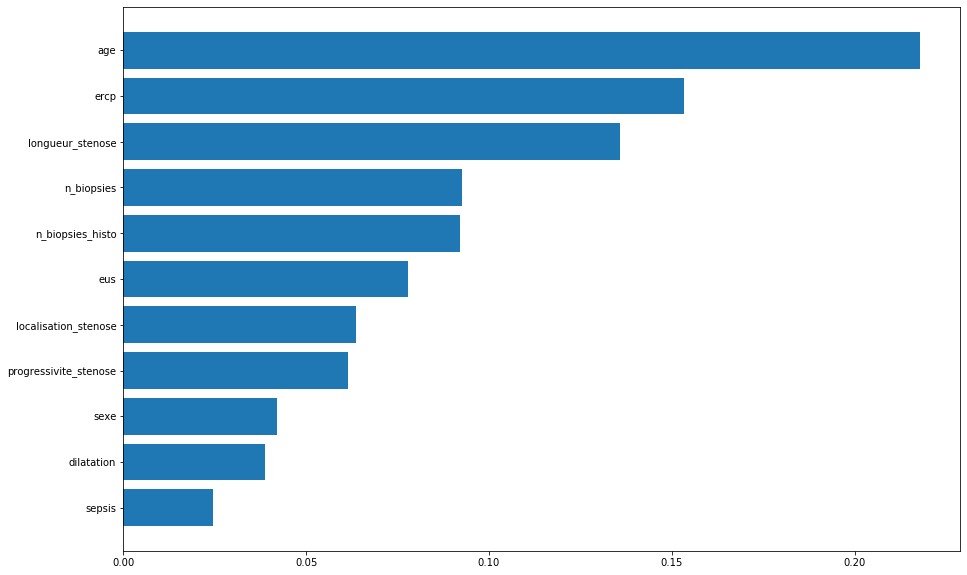

In [15]:
fig, ax = plt.subplots(figsize=(15,10))
sorted_idx = random_forest.feature_importances_.argsort()
ax.barh(db.columns[:-1].values[sorted_idx], random_forest.feature_importances_[sorted_idx])
plt.show()

# III - PLOT TREE

In [17]:
def plot_decision_tree(decision_tree, db, figsize=(15,10)):
    fig, ax = plt.subplots(figsize=figsize)
    tree.plot_tree(decision_tree, ax=ax, fontsize=8,
        filled=True, rounded=True, precision=2, impurity=False,
        feature_names=db.columns.values.tolist(),
        class_names=['Adénocarcinome', 'ADK', 'Autre néoplasie',
                     'Dysplasie', 'Benin', 'Inflammatoire'])
    plt.show()  

In [18]:
def remove_value(annotation):
    text = annotation.get_text()
    remove_start_idx = text.find('samples')
    remove_stop_idx  = text.find('class')
    annotation.set_text(text[:remove_start_idx] + text[remove_stop_idx:])

In [25]:
def custom_plot_tree(decision_tree, db, figsize=(15,10)):
    fig, ax = plt.subplots(figsize=figsize)
    annotations = tree.plot_tree(decision_tree, ax=ax, fontsize=8,
                    filled=True, rounded=True, precision=2, impurity=False,
                    feature_names=db.columns.values.tolist(),
                    class_names=['Adénocarcinome', 'ADK', 'Autre néoplasie',
                                 'Dysplasie', 'Benin', 'Inflammatoire'])
    for annotation in annotations:
        remove_value(annotation)
    plt.show()                

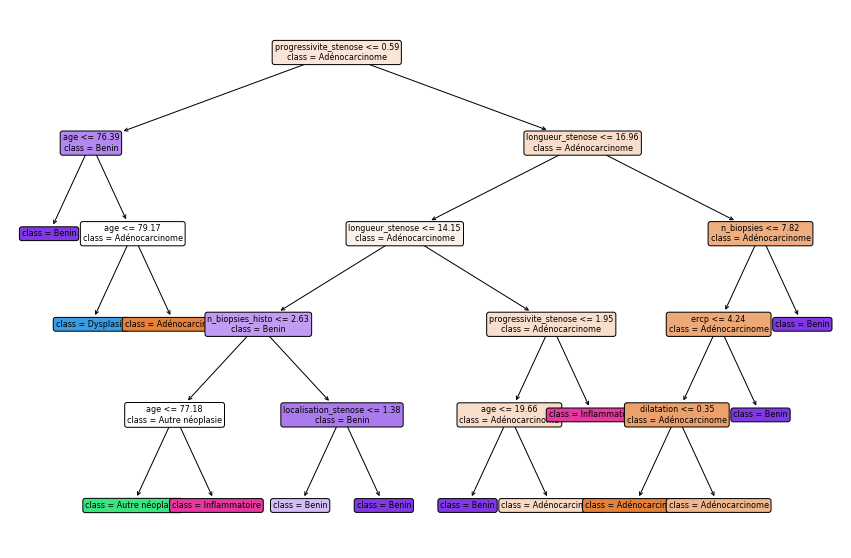

In [26]:
custom_plot_tree(decision_tree, db)

In [27]:
from dtreeviz.trees import dtreeviz

In [28]:
X, y = create_datasets("../medical_data3.csv")

In [29]:
viz = dtreeviz(decision_tree, X, y,
                target_name="target",
                feature_names=db.columns.values.tolist(),
                class_names=['Adénocarcinome', 'ADK', 'Autre néoplasie',
                                 'Dysplasie', 'Benin', 'Inflammatoire'])

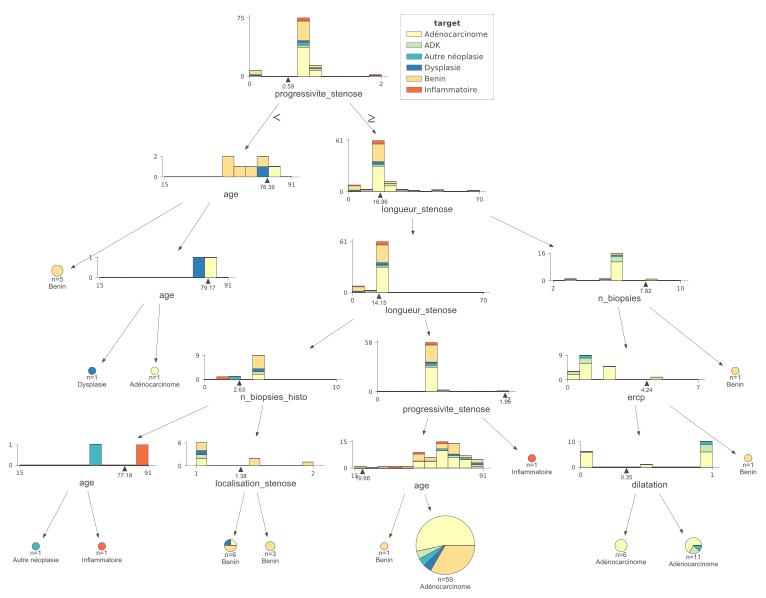

In [32]:
viz

In [33]:
viz.save("detailled_tree.svg")